### Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

### Download data

In [ ]:
#!L

from gfile import download_list

download_list(
    url='https://drive.google.com/file/d/1F96x4LDbsTZGMMq81fZr7aduJCe8N95O',
    filename='celeba.zip',
    target_dir='.'
)

In [ ]:
#!L:bash
unzip celeba.zip

In [5]:
#!L
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid


EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
LATENT_DIMENSION = 4

device = torch.device("cuda")

## Prepare dataset

In [6]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [7]:
#!L
train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
    ]),
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
    ]),
)

---

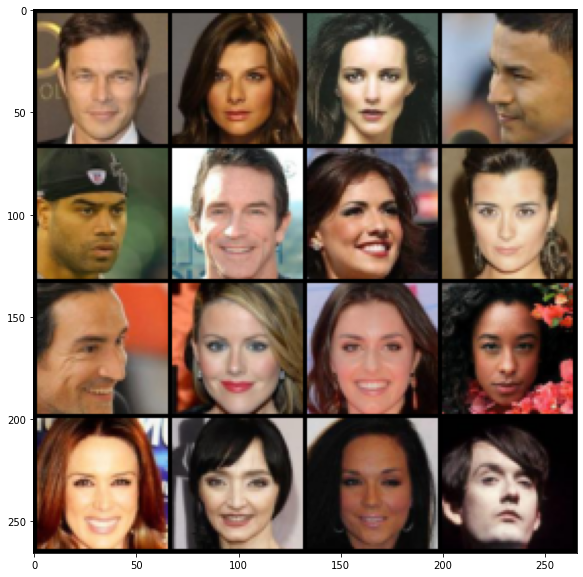

In [8]:
#!L

samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()


### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

**Hint**: you may need nn.Flatten

In [9]:
#!L
class PCAAutoEncoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32):
        super(PCAAutoEncoder, self).__init__()
        
        self.enc = nn.Sequential(
            nn.Linear(3 * 64 * 64, code_size)
        )
        self.dec = nn.Sequential(
            nn.Linear(code_size, 3 * 64 * 64)
        )
    
    def batch_loss(self, batch):
        batch = batch.reshape(batch.shape[0], -1)
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction) ** 2)
    


### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

In [10]:
#!L

%matplotlib inline

from tqdm import trange, tqdm
from IPython import display
from matplotlib import pyplot as plt

def train(model, dataset, num_epoch=32):
    optimizer = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
    
    epoch_losses = []
    for epoch in trange(num_epoch):
        losses = []
    
        for i, (batch, _) in enumerate(dataloader):
            optimizer.zero_grad()
            loss = model.batch_loss(batch.to(device))
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            optimizer.step()
    
        epoch_losses.append(np.mean(losses))
        print(f"#{epoch + 1}, Train loss: {epoch_losses[-1]}")
        
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.plot(epoch_losses)
    ax.set_title(f'loss {epoch_losses[-1]}')
    plt.plot()

In [11]:
#!L
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    code = model.enc(img.to(device).reshape(1, -1))
    reco = model.dec(code)

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1, 3, 2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1, 3, 3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().reshape((3, 64, 64)).transpose([1, 2, 0]).clip(0, 1))
    plt.show()


  2%|▎         | 1/40 [02:30<1:37:34, 150.13s/it]

#1, Train loss: 0.09251069277524948


  5%|▌         | 2/40 [02:51<1:10:41, 111.61s/it]

#2, Train loss: 0.02064197137951851


  8%|▊         | 3/40 [03:13<52:13, 84.69s/it]   

#3, Train loss: 0.012895934283733368


 10%|█         | 4/40 [03:35<39:30, 65.85s/it]

#4, Train loss: 0.012541304342448711


 12%|█▎        | 5/40 [03:57<30:44, 52.70s/it]

#5, Train loss: 0.012476357631385326


 15%|█▌        | 6/40 [04:19<24:39, 43.50s/it]

#6, Train loss: 0.01246772613376379


 18%|█▊        | 7/40 [04:41<20:24, 37.09s/it]

#7, Train loss: 0.012439203448593616


 20%|██        | 8/40 [05:04<17:23, 32.62s/it]

#8, Train loss: 0.012434963136911392


 22%|██▎       | 9/40 [05:26<15:13, 29.48s/it]

#9, Train loss: 0.012432662770152092


 25%|██▌       | 10/40 [05:48<13:37, 27.26s/it]

#10, Train loss: 0.012431645765900612


 28%|██▊       | 11/40 [06:10<12:25, 25.72s/it]

#11, Train loss: 0.01242893934249878


 30%|███       | 12/40 [06:32<11:29, 24.64s/it]

#12, Train loss: 0.012429575435817242


 32%|███▎      | 13/40 [06:54<10:44, 23.85s/it]

#13, Train loss: 0.012430728413164616


 35%|███▌      | 14/40 [07:16<10:06, 23.34s/it]

#14, Train loss: 0.012423408217728138


 38%|███▊      | 15/40 [07:38<09:35, 23.00s/it]

#15, Train loss: 0.0124169010668993


 40%|████      | 16/40 [08:00<09:05, 22.74s/it]

#16, Train loss: 0.01243393961340189


 42%|████▎     | 17/40 [08:23<08:38, 22.53s/it]

#17, Train loss: 0.012432544492185116


 45%|████▌     | 18/40 [08:45<08:13, 22.42s/it]

#18, Train loss: 0.012414978817105293


 48%|████▊     | 19/40 [09:08<07:53, 22.57s/it]

#19, Train loss: 0.012423841282725334


 50%|█████     | 20/40 [09:30<07:28, 22.41s/it]

#20, Train loss: 0.012426342815160751


 52%|█████▎    | 21/40 [09:52<07:03, 22.28s/it]

#21, Train loss: 0.012416674755513668


 55%|█████▌    | 22/40 [10:14<06:40, 22.23s/it]

#22, Train loss: 0.012428012676537037


 57%|█████▊    | 23/40 [10:36<06:17, 22.23s/it]

#23, Train loss: 0.01243164949119091


 60%|██████    | 24/40 [10:58<05:54, 22.15s/it]

#24, Train loss: 0.0124227749183774


 62%|██████▎   | 25/40 [11:20<05:31, 22.12s/it]

#25, Train loss: 0.012420646846294403


 65%|██████▌   | 26/40 [11:42<05:09, 22.09s/it]

#26, Train loss: 0.012434505857527256


 68%|██████▊   | 27/40 [12:04<04:46, 22.05s/it]

#27, Train loss: 0.012416751123964787


 70%|███████   | 28/40 [12:26<04:24, 22.03s/it]

#28, Train loss: 0.012426081113517284


 72%|███████▎  | 29/40 [12:48<04:02, 22.02s/it]

#29, Train loss: 0.012422892265021801


 75%|███████▌  | 30/40 [13:10<03:39, 22.00s/it]

#30, Train loss: 0.012428979389369488


 78%|███████▊  | 31/40 [13:32<03:18, 22.01s/it]

#31, Train loss: 0.012421681545674801


 80%|████████  | 32/40 [13:54<02:55, 21.99s/it]

#32, Train loss: 0.012424948625266552


 82%|████████▎ | 33/40 [14:16<02:34, 22.01s/it]

#33, Train loss: 0.012417619116604328


 85%|████████▌ | 34/40 [14:38<02:12, 22.00s/it]

#34, Train loss: 0.012402979657053947


 88%|████████▊ | 35/40 [15:00<01:50, 22.04s/it]

#35, Train loss: 0.012425861321389675


 90%|█████████ | 36/40 [15:22<01:28, 22.08s/it]

#36, Train loss: 0.012426539324223995


 92%|█████████▎| 37/40 [15:44<01:06, 22.05s/it]

#37, Train loss: 0.012420221231877804


 95%|█████████▌| 38/40 [16:06<00:44, 22.05s/it]

#38, Train loss: 0.012424193322658539


 98%|█████████▊| 39/40 [16:28<00:22, 22.04s/it]

#39, Train loss: 0.012423692271113396


100%|██████████| 40/40 [16:50<00:00, 25.27s/it]

#40, Train loss: 0.012423008680343628


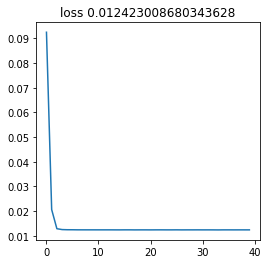

In [12]:
#!L
aenc = PCAAutoEncoder().to(device)
train(aenc, train_dataset, 40)


In [14]:
#!L
dataloader_test = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
scores = []

for i, (batch, _) in tqdm(enumerate(dataloader_test), total=len(dataloader_test.dataset) / BATCH_SIZE):
    scores.append(aenc.batch_loss(batch.to(device)).data.cpu().numpy())

print(np.mean(scores))

100%|█████████▉| 620/620.84375 [03:15<00:00,  2.98it/s]/home/dmitry/.local/lib/python3.6/site-packages/tqdm/std.py:484: TqdmWarning: clamping frac to range [0, 1]
  charset=Bar.ASCII if ascii is True else ascii or Bar.UTF)
100%|██████████| 621/620.84375 [03:16<00:00,  3.17it/s]

0.012271051


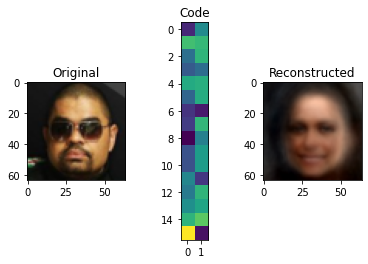

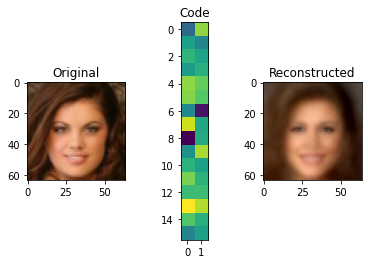

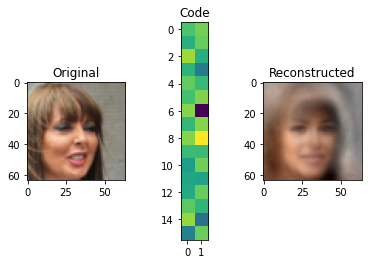

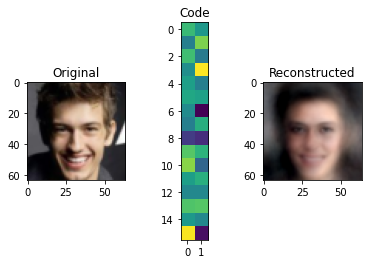

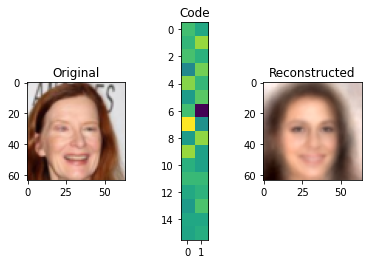

In [15]:
#!L

for i in range(5):
    img = validation_dataset[200 + i][0]
    visualize(img, aenc)

torch.save(aenc.state_dict(), 'pca_aenc_0.012')


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are good idea. To undo convolution use nn.Upsample + nn.Conv2d
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [16]:
#!L

from torch.nn import functional as F

    
class Encoder(nn.Module):
    def __init__(self, code_size):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=2, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=64 * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=64 * 2, out_channels=64 * 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=64*4, out_channels=64*8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=64 * 8, out_channels=64 * 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(),  
            
            nn.Flatten(),
            nn.Linear(8192, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, code_size),
        )
        
    def forward(self, t):
        return self.conv(t)
    

class Decoder(nn.Module):
    def __init__(self, code_size):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(code_size, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 8192),
        )

        self.conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(in_channels=64 * 8, out_channels=64 * 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(),
            
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(in_channels=64 * 8, out_channels=64 * 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(),
            
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(in_channels=64 * 4, out_channels=64 * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(),
            
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(in_channels=64 * 2, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=2, padding=1),
            
            nn.Sigmoid(),
        )
        
    def forward(self, t):
        out = F.leaky_relu(self.linear(t)).view(t.shape[0], 512, 4, 4)
        return self.conv(out)


class DeepPCAAutoEncoder(nn.Module):
    def __init__(self, code_size=32):
        super(DeepPCAAutoEncoder, self).__init__()
        
        
        self.enc = Encoder(code_size)
        self.dec = Decoder(code_size)
    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction) ** 2)


  2%|▏         | 1/50 [10:38<8:41:26, 638.49s/it]

#1, Train loss: 0.01432762946933508


  4%|▍         | 2/50 [17:00<7:29:18, 561.63s/it]

#2, Train loss: 0.009862872771918774


  6%|▌         | 3/50 [23:23<6:37:49, 507.85s/it]

#3, Train loss: 0.00929486658424139


  8%|▊         | 4/50 [29:45<6:00:26, 470.15s/it]

#4, Train loss: 0.009006521664559841


 10%|█         | 5/50 [36:09<5:33:10, 444.23s/it]

#5, Train loss: 0.008807322010397911


 12%|█▏        | 6/50 [42:31<5:12:10, 425.69s/it]

#6, Train loss: 0.00865590013563633


 14%|█▍        | 7/50 [48:54<4:55:48, 412.75s/it]

#7, Train loss: 0.008534555323421955


 16%|█▌        | 8/50 [55:17<4:42:40, 403.81s/it]

#8, Train loss: 0.00844026729464531


 18%|█▊        | 9/50 [1:01:39<4:31:34, 397.42s/it]

#9, Train loss: 0.00835096463561058


 20%|██        | 10/50 [1:08:02<4:22:08, 393.22s/it]

#10, Train loss: 0.008278464898467064


 22%|██▏       | 11/50 [1:14:25<4:13:31, 390.04s/it]

#11, Train loss: 0.008210129104554653


 24%|██▍       | 12/50 [1:20:52<4:06:23, 389.04s/it]

#12, Train loss: 0.008144550025463104


 26%|██▌       | 13/50 [1:27:16<3:58:58, 387.53s/it]

#13, Train loss: 0.008091077208518982


 28%|██▊       | 14/50 [1:33:38<3:51:36, 386.00s/it]

#14, Train loss: 0.008037833496928215


 30%|███       | 15/50 [1:40:01<3:44:34, 384.99s/it]

#15, Train loss: 0.007991028018295765


 32%|███▏      | 16/50 [1:46:23<3:37:45, 384.27s/it]

#16, Train loss: 0.007943600416183472


 34%|███▍      | 17/50 [1:52:46<3:31:05, 383.80s/it]

#17, Train loss: 0.007894514128565788


 36%|███▌      | 18/50 [1:59:09<3:24:31, 383.48s/it]

#18, Train loss: 0.007861966267228127


 38%|███▊      | 19/50 [2:05:32<3:18:02, 383.29s/it]

#19, Train loss: 0.00781439058482647


 40%|████      | 20/50 [2:11:55<3:11:34, 383.14s/it]

#20, Train loss: 0.007786550093442202


 42%|████▏     | 21/50 [2:18:17<3:05:06, 383.00s/it]

#21, Train loss: 0.007749259937554598


 44%|████▍     | 22/50 [2:24:40<2:58:41, 382.92s/it]

#22, Train loss: 0.0077178762294352055


 46%|████▌     | 23/50 [2:31:08<2:53:01, 384.49s/it]

#23, Train loss: 0.0076864929869771


 48%|████▊     | 24/50 [2:37:33<2:46:40, 384.64s/it]

#24, Train loss: 0.00765187619253993


 50%|█████     | 25/50 [2:43:56<2:40:05, 384.22s/it]

#25, Train loss: 0.007625963073223829


 52%|█████▏    | 26/50 [2:50:19<2:33:30, 383.78s/it]

#26, Train loss: 0.007597338408231735


 54%|█████▍    | 27/50 [2:56:42<2:26:59, 383.47s/it]

#27, Train loss: 0.007562899962067604


 56%|█████▌    | 28/50 [3:03:05<2:20:32, 383.28s/it]

#28, Train loss: 0.0075395554304122925


 58%|█████▊    | 29/50 [3:09:28<2:14:06, 383.16s/it]

#29, Train loss: 0.007510584779083729


 60%|██████    | 30/50 [3:15:50<2:07:41, 383.07s/it]

#30, Train loss: 0.007485532201826572


 62%|██████▏   | 31/50 [3:22:13<2:01:16, 383.00s/it]

#31, Train loss: 0.007466709241271019


 64%|██████▍   | 32/50 [3:28:36<1:54:52, 382.94s/it]

#32, Train loss: 0.007436773739755154


 66%|██████▌   | 33/50 [3:34:59<1:48:29, 382.88s/it]

#33, Train loss: 0.007410865742713213


 68%|██████▊   | 34/50 [3:41:21<1:42:05, 382.82s/it]

#34, Train loss: 0.007384494878351688


 70%|███████   | 35/50 [3:47:44<1:35:42, 382.85s/it]

#35, Train loss: 0.00736048212274909


 72%|███████▏  | 36/50 [3:54:07<1:29:18, 382.78s/it]

#36, Train loss: 0.007341458927839994


 74%|███████▍  | 37/50 [4:00:30<1:22:55, 382.75s/it]

#37, Train loss: 0.007314320188015699


 76%|███████▌  | 38/50 [4:06:52<1:16:31, 382.66s/it]

#38, Train loss: 0.0072939335368573666


 78%|███████▊  | 39/50 [4:13:15<1:10:09, 382.69s/it]

#39, Train loss: 0.0072715748101472855


 80%|████████  | 40/50 [4:19:37<1:03:46, 382.66s/it]

#40, Train loss: 0.007249858696013689


 82%|████████▏ | 41/50 [4:26:00<57:23, 382.62s/it]  

#41, Train loss: 0.007227085996419191


 84%|████████▍ | 42/50 [4:32:22<51:00, 382.57s/it]

#42, Train loss: 0.007207746151834726


 86%|████████▌ | 43/50 [4:38:45<44:37, 382.54s/it]

#43, Train loss: 0.007189092691987753


 88%|████████▊ | 44/50 [4:45:07<38:15, 382.53s/it]

#44, Train loss: 0.007167436648160219


 90%|█████████ | 45/50 [4:51:30<31:52, 382.48s/it]

#45, Train loss: 0.007150827441364527


 92%|█████████▏| 46/50 [4:57:52<25:29, 382.45s/it]

#46, Train loss: 0.007126148324459791


 94%|█████████▍| 47/50 [5:04:14<19:07, 382.42s/it]

#47, Train loss: 0.007108591962605715


 96%|█████████▌| 48/50 [5:10:37<12:44, 382.39s/it]

#48, Train loss: 0.007087319158017635


 98%|█████████▊| 49/50 [5:16:59<06:22, 382.43s/it]

#49, Train loss: 0.00707325991243124


100%|██████████| 50/50 [5:23:22<00:00, 388.04s/it]

#50, Train loss: 0.007051469758152962


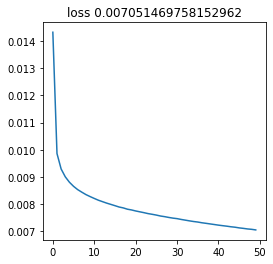

In [19]:
#!L
aenc_deep = DeepPCAAutoEncoder().to(device)
aenc_deep = aenc_deep.train()
train(aenc_deep, train_dataset, 50)

In [47]:
torch.save(aenc_deep.state_dict(), 'deep_aenc')

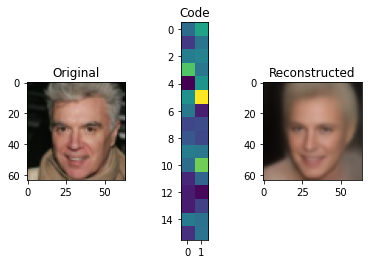

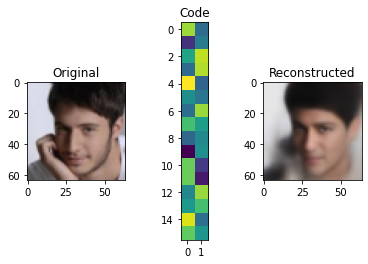

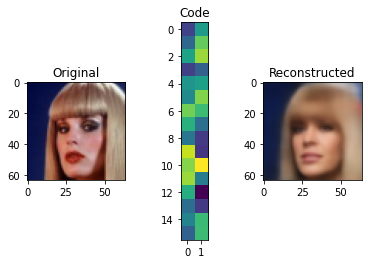

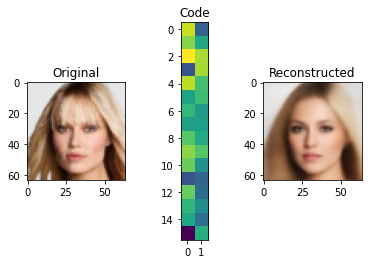

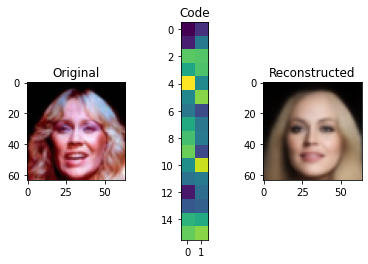

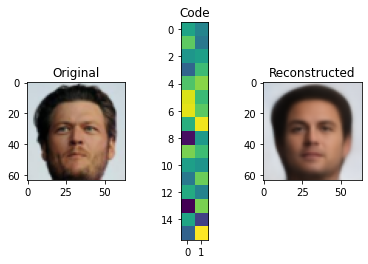

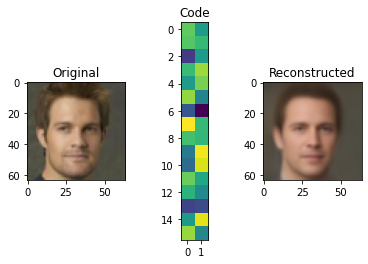

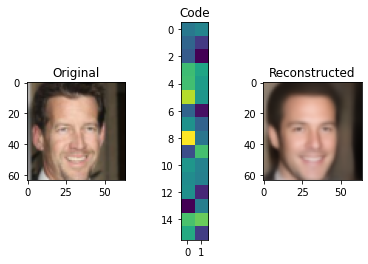

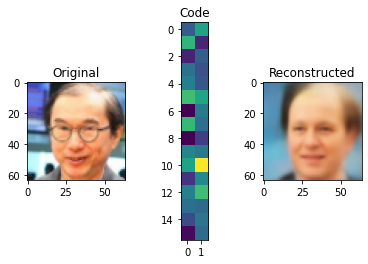

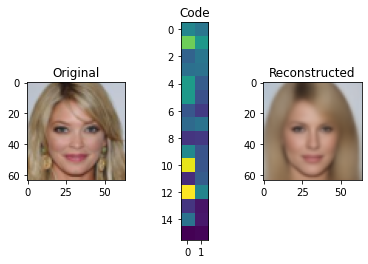

In [21]:
#!L

def visualize(img, model):
    """Draws original, encoded and decoded images"""
    code = model.enc(img[None].to(device))
    reco = model.dec(code)

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1, 3, 2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1, 3, 3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


for i in range(10):
    img = validation_dataset[i + 7][0]
    visualize(img, aenc_deep.eval())


Training may take long, it's okay.

**Check autoencoder shapes along different code_sizes. Check architecture of you encoder-decoder network is correct**

In [28]:
#!L
def get_dim(layer): return np.prod(layer.output_shape[1:])


for code_size in [1, 8, 32, 128, 512, 1024]:
    help_tensor = next(iter(DataLoader(train_dataset, batch_size=BATCH_SIZE)))
    model = DeepPCAAutoEncoder(code_size).to(device)
    img = help_tensor[0]
    encoder_out = model.enc(img.to(device))
    decoder_out = model.dec(encoder_out)

    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size(
        [code_size]), "encoder must output a code of required size"
    assert decoder_out.shape[1:] == img.shape[1:], "decoder must output an image of valid shape"
    # assert len(list(model.dec.children())) >= 6,  "decoder must contain at least 3 dense layers"

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

** Lets check you model's score. You should beat value of 0.005 **

In [ ]:
#!L
dataloader_test = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=8, pin_memory=True)
scores = []
for i, (batch, _) in tqdm(enumerate(dataloader_test), total=len(dataloader_test.dataset) / BATCH_SIZE):
    scores.append(aenc_deep.batch_loss(batch.to(device)).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch.to(device))

reconstruction_mse = np.mean(scores)

assert reconstruction_mse <= 0.005, f"{reconstruction_mse} Compression is too lossy. See tips below."
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 32, \
    "Make sure encoder has code_size units"

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = validation_dataset[i][0]
    visualize(img, aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [22]:
#!L
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
        
    total = len(X.view(-1))
    noise = torch.normal(mean=torch.zeros(total), std=torch.zeros(total) + sigma).view(X.shape)
        
    return X + noise
    

**noise tests**

In [23]:
#!L
X = torch.stack([train_dataset[i][0] for i in range(100)], dim=0)
theoretical_std = (X.std() ** 2 + 0.5 ** 2) ** .5
our_std = apply_gaussian_noise(X, sigma=0.5).std()

assert abs(theoretical_std - our_std) < 0.01, \
    "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X, sigma=0.5).mean() - X.mean()) < 0.01, \
    "Mean has changed. Please add zero-mean noise"

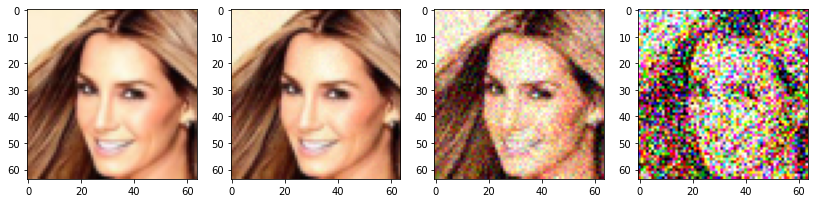

In [24]:
#!L
plt.figure(figsize=(14, 4))
plt.subplot(1, 4, 1)
plt.imshow(X[0].permute([1, 2, 0]))
plt.subplot(1, 4, 2)
plt.imshow(apply_gaussian_noise(X[:1], sigma=0.01)[0].permute([1, 2, 0]).clamp(0, 1))
plt.subplot(1, 4, 3)
plt.imshow(apply_gaussian_noise(X[:1], sigma=0.1)[0].permute([1, 2, 0]).clamp(0, 1))
plt.subplot(1, 4, 4)
plt.imshow(apply_gaussian_noise(X[:1], sigma=0.5)[0].permute([1, 2, 0]).clamp(0, 1))

In [33]:
class NoisyDeepPCAAutoEncoder(nn.Module):
    def __init__(self, code_size=32):
        super(NoisyDeepPCAAutoEncoder, self).__init__()
        
        
        self.enc = Encoder(code_size)
        self.dec = Decoder(code_size)
    
    def batch_loss(self, batch, expected):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((expected - reconstruction) ** 2)

In [34]:
#!L

%matplotlib inline

from tqdm import trange, tqdm
from IPython import display
from matplotlib import pyplot as plt

def train_noise(model, dataset, num_epoch=50):
    optimizer = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
    
    epoch_losses = []
    for epoch in trange(num_epoch):
        losses = []
    
        for i, (batch, _) in enumerate(dataloader):
            noisy_batch = apply_gaussian_noise(batch)
            optimizer.zero_grad()
            loss = model.batch_loss(batch.to(device), noisy_batch.to(device))
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            optimizer.step()
    
        epoch_losses.append(np.mean(losses))
        print(f"#{epoch + 1}, Train loss: {epoch_losses[-1]}")
        
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.plot(epoch_losses)
    ax.set_title(f'loss {epoch_losses[-1]}')
    plt.plot()

__Note:__ You may change the way the training with noise is done, if you want. For example, you may change Dataloader or batch_loss function in model and leave train function unchanged.

  2%|▏         | 1/50 [06:19<5:09:46, 379.31s/it]

#1, Train loss: 0.024276496842503548


  4%|▍         | 2/50 [12:44<5:04:57, 381.20s/it]

#2, Train loss: 0.01985708624124527


  6%|▌         | 3/50 [19:08<4:59:12, 381.98s/it]

#3, Train loss: 0.01928708143532276


  8%|▊         | 4/50 [25:32<4:53:15, 382.51s/it]

#4, Train loss: 0.019001340493559837


 10%|█         | 5/50 [31:55<4:47:05, 382.79s/it]

#5, Train loss: 0.01880577765405178


 12%|█▏        | 6/50 [38:19<4:40:49, 382.94s/it]

#6, Train loss: 0.018662866204977036


 14%|█▍        | 7/50 [44:42<4:34:34, 383.14s/it]

#7, Train loss: 0.018532518297433853


 16%|█▌        | 8/50 [51:06<4:28:17, 383.27s/it]

#8, Train loss: 0.018443237990140915


 18%|█▊        | 9/50 [57:30<4:22:02, 383.47s/it]

#9, Train loss: 0.018355797976255417


 20%|██        | 10/50 [1:03:54<4:15:44, 383.60s/it]

#10, Train loss: 0.01828296296298504


 22%|██▏       | 11/50 [1:10:18<4:09:28, 383.80s/it]

#11, Train loss: 0.01821233332157135


 24%|██▍       | 12/50 [1:16:42<4:03:07, 383.88s/it]

#12, Train loss: 0.01815328188240528


 26%|██▌       | 13/50 [1:23:06<3:56:46, 383.95s/it]

#13, Train loss: 0.018098339438438416


 28%|██▊       | 14/50 [1:29:30<3:50:24, 384.00s/it]

#14, Train loss: 0.018050819635391235


 30%|███       | 15/50 [1:35:57<3:44:25, 384.74s/it]

#15, Train loss: 0.01800130121409893


 32%|███▏      | 16/50 [1:42:21<3:37:59, 384.68s/it]

#16, Train loss: 0.017952604219317436


 34%|███▍      | 17/50 [1:48:46<3:31:33, 384.66s/it]

#17, Train loss: 0.017918426543474197


 36%|███▌      | 18/50 [1:55:10<3:25:07, 384.61s/it]

#18, Train loss: 0.017873581498861313


 38%|███▊      | 19/50 [2:01:35<3:18:44, 384.66s/it]

#19, Train loss: 0.017841054126620293


 40%|████      | 20/50 [2:08:00<3:12:21, 384.72s/it]

#20, Train loss: 0.017797645181417465


 42%|████▏     | 21/50 [2:14:25<3:05:57, 384.74s/it]

#21, Train loss: 0.01776609942317009


 44%|████▍     | 22/50 [2:20:50<2:59:35, 384.82s/it]

#22, Train loss: 0.017736107110977173


 46%|████▌     | 23/50 [2:27:15<2:53:10, 384.85s/it]

#23, Train loss: 0.017703913152217865


 48%|████▊     | 24/50 [2:33:40<2:46:48, 384.94s/it]

#24, Train loss: 0.017670271918177605


 50%|█████     | 25/50 [2:40:05<2:40:25, 385.01s/it]

#25, Train loss: 0.017639916390180588


 52%|█████▏    | 26/50 [2:46:30<2:34:00, 385.03s/it]

#26, Train loss: 0.01761319488286972


 54%|█████▍    | 27/50 [2:52:56<2:27:38, 385.15s/it]

#27, Train loss: 0.01758483424782753


 56%|█████▌    | 28/50 [2:59:21<2:21:13, 385.14s/it]

#28, Train loss: 0.01755855791270733


 58%|█████▊    | 29/50 [3:05:46<2:14:49, 385.20s/it]

#29, Train loss: 0.017533931881189346


 60%|██████    | 30/50 [3:12:11<2:08:24, 385.21s/it]

#30, Train loss: 0.01750052534043789


 62%|██████▏   | 31/50 [3:18:37<2:02:00, 385.27s/it]

#31, Train loss: 0.017478832975029945


 64%|██████▍   | 32/50 [3:25:02<1:55:35, 385.31s/it]

#32, Train loss: 0.01745186373591423


 66%|██████▌   | 33/50 [3:31:28<1:49:11, 385.40s/it]

#33, Train loss: 0.017428377643227577


 68%|██████▊   | 34/50 [3:37:53<1:42:46, 385.44s/it]

#34, Train loss: 0.017405306920409203


 70%|███████   | 35/50 [3:44:19<1:36:21, 385.42s/it]

#35, Train loss: 0.017381835728883743


 72%|███████▏  | 36/50 [3:50:44<1:29:55, 385.41s/it]

#36, Train loss: 0.017358731478452682


 74%|███████▍  | 37/50 [3:57:10<1:23:30, 385.45s/it]

#37, Train loss: 0.01733846217393875


 76%|███████▌  | 38/50 [4:03:35<1:17:05, 385.45s/it]

#38, Train loss: 0.01731950230896473


 78%|███████▊  | 39/50 [4:10:01<1:10:40, 385.50s/it]

#39, Train loss: 0.017301088199019432


 80%|████████  | 40/50 [4:16:26<1:04:14, 385.49s/it]

#40, Train loss: 0.0172729454934597


 82%|████████▏ | 41/50 [4:22:52<57:50, 385.62s/it]  

#41, Train loss: 0.017251404002308846


 84%|████████▍ | 42/50 [4:29:18<51:24, 385.61s/it]

#42, Train loss: 0.017232175916433334


 86%|████████▌ | 43/50 [4:35:43<44:58, 385.57s/it]

#43, Train loss: 0.01720915362238884


 88%|████████▊ | 44/50 [4:42:08<38:33, 385.51s/it]

#44, Train loss: 0.017196670174598694


 90%|█████████ | 45/50 [4:48:34<32:07, 385.53s/it]

#45, Train loss: 0.01717177778482437


 92%|█████████▏| 46/50 [4:54:59<25:42, 385.52s/it]

#46, Train loss: 0.017154620960354805


 94%|█████████▍| 47/50 [5:01:25<19:16, 385.55s/it]

#47, Train loss: 0.017133615911006927


 96%|█████████▌| 48/50 [5:07:51<12:51, 385.54s/it]

#48, Train loss: 0.017116498202085495


 98%|█████████▊| 49/50 [5:14:16<06:25, 385.54s/it]

#49, Train loss: 0.017095090821385384


100%|██████████| 50/50 [5:20:42<00:00, 384.84s/it]

#50, Train loss: 0.01707802154123783


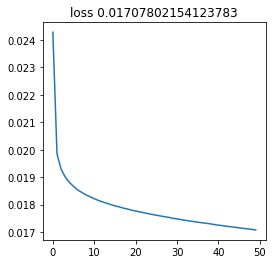

In [59]:
#!L
aenc = NoisyDeepPCAAutoEncoder().to(device)
train_noise(aenc, train_dataset, 50)

torch.save(aenc.state_dict(), 'deep_noisy_aenc')


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

**Let's evaluate!!!**


  0%|          | 0/620.84375 [00:00<?, ?it/s]
  0%|          | 1/620.84375 [00:01<12:21,  1.20s/it]
  0%|          | 2/620.84375 [00:01<09:07,  1.13it/s]
  1%|          | 5/620.84375 [00:01<06:28,  1.59it/s]
  1%|▏         | 9/620.84375 [00:02<04:56,  2.07it/s]
  2%|▏         | 10/620.84375 [00:02<04:57,  2.05it/s]
  2%|▏         | 14/620.84375 [00:02<03:32,  2.85it/s]
  3%|▎         | 17/620.84375 [00:03<02:50,  3.55it/s]
  3%|▎         | 19/620.84375 [00:03<02:46,  3.61it/s]
  4%|▎         | 23/620.84375 [00:03<02:01,  4.93it/s]
  4%|▍         | 25/620.84375 [00:03<01:52,  5.32it/s]
  4%|▍         | 27/620.84375 [00:04<02:26,  4.04it/s]
  5%|▍         | 31/620.84375 [00:04<01:47,  5.50it/s]
  5%|▌         | 33/620.84375 [00:04<01:26,  6.79it/s]
  6%|▌         | 35/620.84375 [00:05<02:06,  4.63it/s]
  6%|▋         | 39/620.84375 [00:05<01:33,  6.25it/s]
  7%|▋         | 41/620.84375 [00:06<01:27,  6.63it/s]
  7%|▋         | 43/620.84375 [00:06<01:27,  6.60it/s]
  8%|▊         | 47/62

 67%|██████▋   | 413/620.84375 [00:51<00:37,  5.62it/s]
 67%|██████▋   | 417/620.84375 [00:51<00:27,  7.47it/s]
 68%|██████▊   | 421/620.84375 [00:51<00:26,  7.47it/s]
 68%|██████▊   | 425/620.84375 [00:52<00:20,  9.75it/s]
 69%|██████▉   | 428/620.84375 [00:52<00:18, 10.71it/s]
 69%|██████▉   | 430/620.84375 [00:52<00:29,  6.55it/s]
 70%|██████▉   | 434/620.84375 [00:53<00:25,  7.32it/s]
 70%|███████   | 437/620.84375 [00:53<00:25,  7.34it/s]
 71%|███████   | 441/620.84375 [00:53<00:18,  9.59it/s]
 71%|███████▏  | 443/620.84375 [00:54<00:28,  6.32it/s]
 72%|███████▏  | 445/620.84375 [00:54<00:29,  6.02it/s]
 72%|███████▏  | 449/620.84375 [00:54<00:21,  7.99it/s]
 73%|███████▎  | 451/620.84375 [00:54<00:19,  8.65it/s]
 73%|███████▎  | 453/620.84375 [00:55<00:29,  5.63it/s]
 74%|███████▎  | 457/620.84375 [00:55<00:21,  7.53it/s]
 74%|███████▍  | 459/620.84375 [00:56<00:24,  6.73it/s]
 74%|███████▍  | 461/620.84375 [00:56<00:23,  6.75it/s]
 75%|███████▍  | 465/620.84375 [00:56<00:17,  8.

Final MSE: 0.00820735


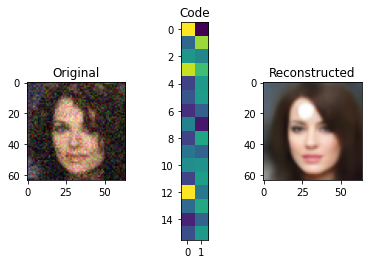

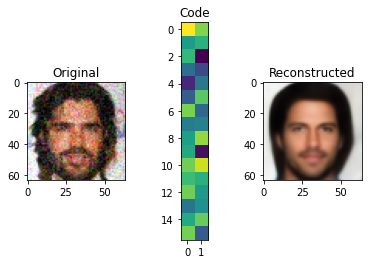

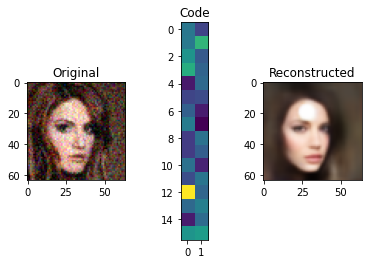

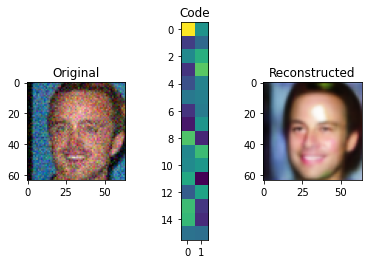

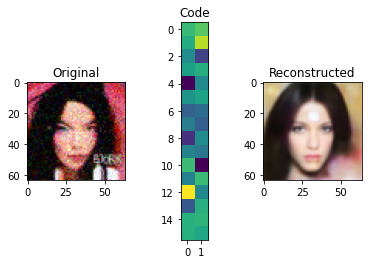

In [61]:
#!L
dataloader_test = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
scores = []

for i, (batch, _) in tqdm(enumerate(dataloader_test), total=len(dataloader_test.dataset) / BATCH_SIZE):
    scores.append(aenc.batch_loss(batch.to(device), batch.to(device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch.to(device))

reconstruction_mse = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = validation_dataset[i][0]
    visualize(apply_gaussian_noise(img), aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [70]:
#!L
# encodes batch of images into a codes

aenc = DeepPCAAutoEncoder().to(device)
aenc.load_state_dict(torch.load('deep_aenc'))
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

codes = []
for batch, _ in tqdm(dataloader, total=len(dataloader.dataset) / BATCH_SIZE):
    with torch.no_grad():
        enc = aenc.enc(batch.to(device))
        codes.extend(enc.cpu().numpy())

codes = np.array(codes)


  0%|          | 0/5086.5625 [00:00<?, ?it/s]
  0%|          | 1/5086.5625 [00:00<23:03,  3.68it/s]
  0%|          | 10/5086.5625 [00:00<16:23,  5.16it/s]
  0%|          | 19/5086.5625 [00:00<11:44,  7.19it/s]
  1%|          | 28/5086.5625 [00:00<08:29,  9.92it/s]
  1%|          | 37/5086.5625 [00:00<06:13, 13.52it/s]
  1%|          | 48/5086.5625 [00:00<04:35, 18.29it/s]
  1%|          | 60/5086.5625 [00:00<03:26, 24.39it/s]
  1%|▏         | 72/5086.5625 [00:01<02:37, 31.86it/s]
  2%|▏         | 83/5086.5625 [00:01<02:03, 40.41it/s]
  2%|▏         | 94/5086.5625 [00:01<01:40, 49.77it/s]
  2%|▏         | 105/5086.5625 [00:01<01:23, 59.54it/s]
  2%|▏         | 117/5086.5625 [00:01<01:11, 69.08it/s]
  3%|▎         | 128/5086.5625 [00:01<01:03, 77.57it/s]
  3%|▎         | 140/5086.5625 [00:01<00:58, 85.17it/s]
  3%|▎         | 151/5086.5625 [00:01<00:54, 91.03it/s]
  3%|▎         | 162/5086.5625 [00:01<00:51, 95.76it/s]
  3%|▎         | 173/5086.5625 [00:01<00:49, 99.18it/s]
  4%|▎      

 30%|██▉       | 1523/5086.5625 [00:14<00:31, 112.42it/s]
 30%|███       | 1535/5086.5625 [00:14<00:31, 111.43it/s]
 30%|███       | 1547/5086.5625 [00:14<00:31, 110.94it/s]
 31%|███       | 1559/5086.5625 [00:14<00:32, 109.82it/s]
 31%|███       | 1571/5086.5625 [00:14<00:31, 110.20it/s]
 31%|███       | 1583/5086.5625 [00:14<00:31, 111.04it/s]
 31%|███▏      | 1595/5086.5625 [00:14<00:31, 111.19it/s]
 32%|███▏      | 1607/5086.5625 [00:14<00:31, 111.35it/s]
 32%|███▏      | 1619/5086.5625 [00:15<00:30, 111.92it/s]
 32%|███▏      | 1631/5086.5625 [00:15<00:30, 112.15it/s]
 32%|███▏      | 1643/5086.5625 [00:15<00:30, 112.73it/s]
 33%|███▎      | 1655/5086.5625 [00:15<00:30, 112.97it/s]
 33%|███▎      | 1667/5086.5625 [00:15<00:30, 112.59it/s]
 33%|███▎      | 1679/5086.5625 [00:15<00:30, 112.78it/s]
 33%|███▎      | 1691/5086.5625 [00:15<00:30, 113.00it/s]
 33%|███▎      | 1703/5086.5625 [00:15<00:29, 113.32it/s]
 34%|███▎      | 1715/5086.5625 [00:15<00:29, 113.28it/s]
 34%|███▍     

 62%|██████▏   | 3131/5086.5625 [00:28<00:17, 112.61it/s]
 62%|██████▏   | 3143/5086.5625 [00:28<00:17, 112.54it/s]
 62%|██████▏   | 3155/5086.5625 [00:28<00:17, 112.73it/s]
 62%|██████▏   | 3167/5086.5625 [00:28<00:17, 112.79it/s]
 62%|██████▏   | 3179/5086.5625 [00:28<00:16, 112.58it/s]
 63%|██████▎   | 3191/5086.5625 [00:28<00:16, 112.68it/s]
 63%|██████▎   | 3203/5086.5625 [00:29<00:16, 112.82it/s]
 63%|██████▎   | 3215/5086.5625 [00:29<00:16, 113.00it/s]
 63%|██████▎   | 3227/5086.5625 [00:29<00:16, 112.62it/s]
 64%|██████▎   | 3239/5086.5625 [00:29<00:16, 112.77it/s]
 64%|██████▍   | 3251/5086.5625 [00:29<00:16, 112.84it/s]
 64%|██████▍   | 3263/5086.5625 [00:29<00:16, 112.86it/s]
 64%|██████▍   | 3275/5086.5625 [00:29<00:16, 112.73it/s]
 65%|██████▍   | 3287/5086.5625 [00:29<00:15, 112.72it/s]
 65%|██████▍   | 3299/5086.5625 [00:29<00:15, 112.70it/s]
 65%|██████▌   | 3311/5086.5625 [00:30<00:15, 112.62it/s]
 65%|██████▌   | 3323/5086.5625 [00:30<00:15, 112.55it/s]
 66%|██████▌  

 92%|█████████▏| 4698/5086.5625 [00:42<00:03, 107.44it/s]
 93%|█████████▎| 4709/5086.5625 [00:42<00:03, 107.41it/s]
 93%|█████████▎| 4721/5086.5625 [00:42<00:03, 108.56it/s]
 93%|█████████▎| 4733/5086.5625 [00:43<00:03, 109.56it/s]
 93%|█████████▎| 4745/5086.5625 [00:43<00:03, 110.11it/s]
 94%|█████████▎| 4757/5086.5625 [00:43<00:02, 110.53it/s]
 94%|█████████▍| 4769/5086.5625 [00:43<00:02, 111.01it/s]
 94%|█████████▍| 4781/5086.5625 [00:43<00:02, 111.34it/s]
 94%|█████████▍| 4793/5086.5625 [00:43<00:02, 111.45it/s]
 94%|█████████▍| 4805/5086.5625 [00:43<00:02, 109.31it/s]
 95%|█████████▍| 4816/5086.5625 [00:43<00:02, 107.14it/s]
 95%|█████████▍| 4827/5086.5625 [00:43<00:02, 106.88it/s]
 95%|█████████▌| 4838/5086.5625 [00:43<00:02, 106.84it/s]
 95%|█████████▌| 4849/5086.5625 [00:44<00:02, 106.58it/s]
 96%|█████████▌| 4860/5086.5625 [00:44<00:02, 106.24it/s]
 96%|█████████▌| 4871/5086.5625 [00:44<00:02, 106.01it/s]
 96%|█████████▌| 4882/5086.5625 [00:44<00:01, 107.10it/s]
 96%|█████████

In [76]:
#!L
assert codes.shape[0] == len(train_dataset)

In [83]:
#!L
from sklearn.neighbors import KNeighborsClassifier
lshf = KNeighborsClassifier(n_neighbors=50).fit(codes, list(range(len(codes))))

In [117]:
#!L
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [3,height,width]"

    with torch.no_grad():
        code = aenc.enc(torch.tensor(image).unsqueeze(dim=0).to(device)).cpu().numpy()

    (distances,), (idx,) =  lshf.kneighbors(code, n_neighbors)

    return distances, [train_dataset[i][0] for i in idx]

In [118]:
#!L
def show_similar(image):

    distances, neighbors = get_similar(image, n_neighbors=11)

    plt.figure(figsize=[8, 6])
    plt.subplot(3, 4, 1)
    plt.imshow(image.cpu().numpy().transpose([1, 2, 0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3, 4, i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1, 2, 0]))
        plt.title("Dist=%.3f" % distances[i])
    plt.show()

/home/dmitry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


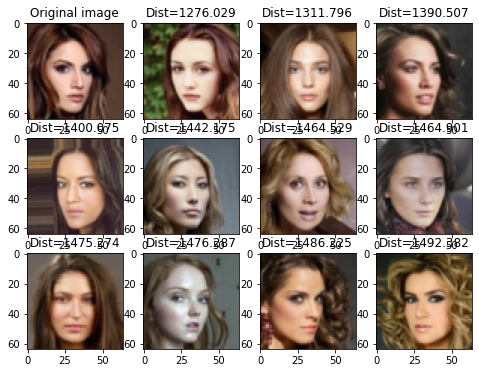

In [119]:
#!L
show_similar(validation_dataset[2][0])

/home/dmitry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


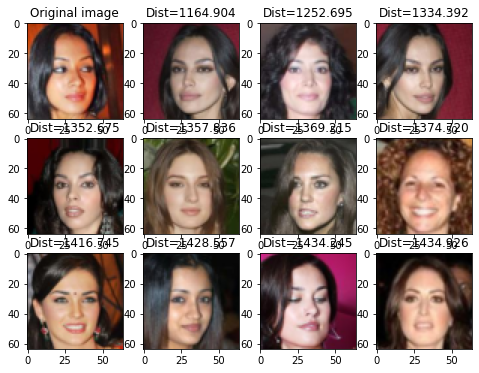

In [120]:
#!L
show_similar(validation_dataset[500][0])

/home/dmitry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


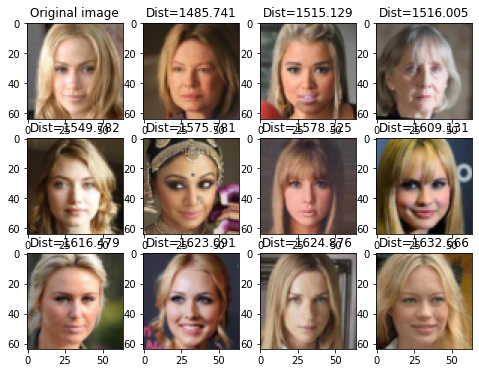

In [121]:
#!L
show_similar(validation_dataset[66][0])

## Cheap image morphing


Here you should take two full-sized objects, code it and obtain intermediate object by decoding an intermixture code.

$Code_{mixt} = a1\cdot code1 + a2\cdot code2$

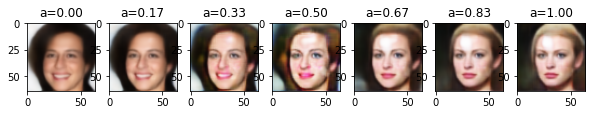

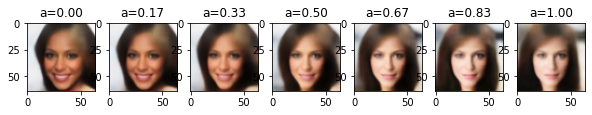

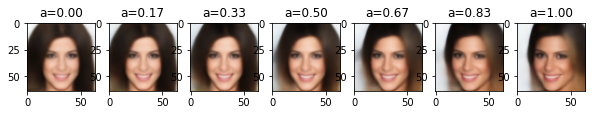

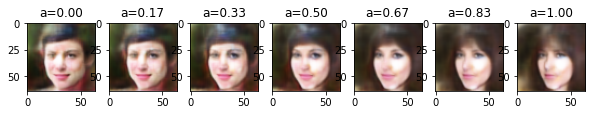

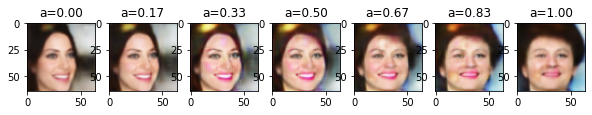

In [139]:
#!L
for _ in range(5):
    image1 = train_dataset[np.random.randint(0, len(train_dataset))][0]
    image2 = train_dataset[np.random.randint(0, len(train_dataset))][0]
    
    with torch.no_grad():
        code1 = aenc.enc(image1.unsqueeze(dim=0).to(device))
        code2 = aenc.enc(image2.unsqueeze(dim=0).to(device))

    plt.figure(figsize=[10, 4])
    for i, a in enumerate(np.linspace(0, 1, num=7)):

        output_code =  a * code1 + (1 - a) * code2

        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1, 7, i+1)
        plt.imshow(output_image.cpu().detach().numpy().transpose([1, 2, 0]))
        plt.title("a=%.2f" % a)

    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.